model_name = inception 
data_input =  audio 
win_len = 100 hop = 200 
optim = Adam lr=0.0001 
mask_y_len = 10 mask_x_len = 10 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 16 batch_val = 32  
n_epochs = 100 split = individ 
Finished Training in 1.6894962390263875
Maxx val acc: 81.8


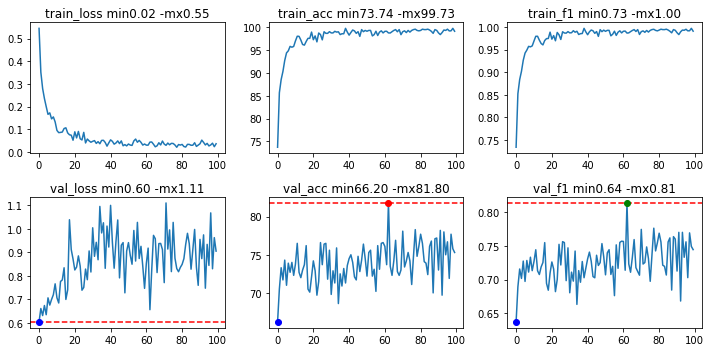

In [1]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 200
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 16
batch_val = 32 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 10
mask_x_len = 10
lr=1e-4
model_name = "inception"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.2,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 100 hop = 200 
optim = Adam lr=0.0001 
mask_y_len = 10 mask_x_len = 10 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 32  
n_epochs = 100 split = individ 
Finished Training in 2.889818775653839
Maxx val acc: 80.9


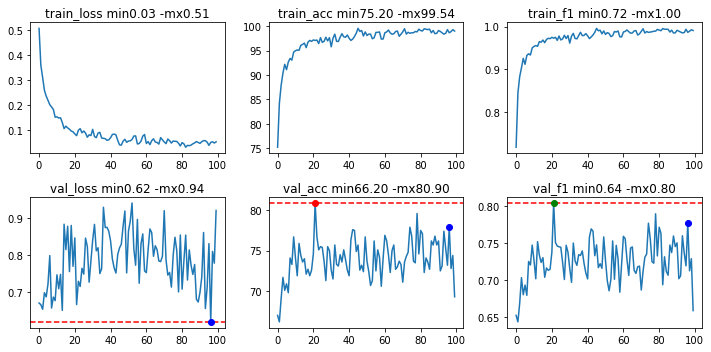

In [2]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 200
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 32 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 10
mask_x_len = 10
lr=1e-4
model_name = "inception"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.2,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 100 hop = 200 
optim = Adam lr=0.0001 
mask_y_len = 10 mask_x_len = 10 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 32  
n_epochs = 100 split = individ 
Finished Training in 2.9652840733528136
Maxx val acc: 79.9


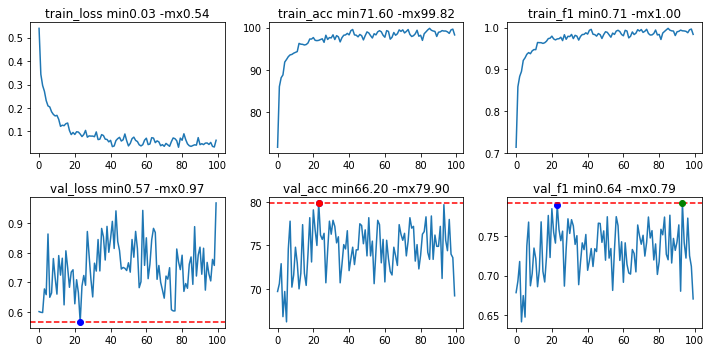

In [3]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 200
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 32 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 10
mask_x_len = 10
lr=1e-4
model_name = "inception"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 100 hop = 200 
optim = Adam lr=0.0001 
mask_y_len = 10 mask_x_len = 10 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 3.170337025324504
Maxx val acc: 79.23076923076923


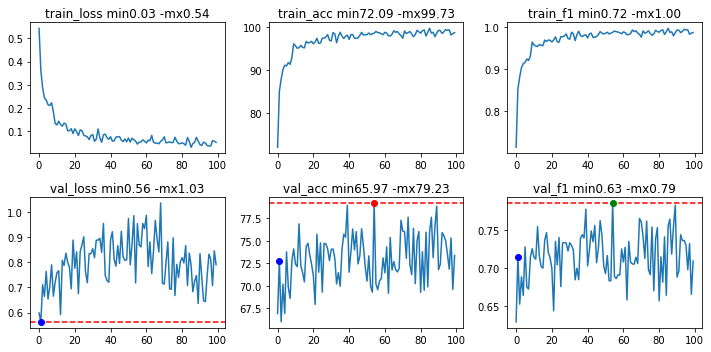

In [4]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 200
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 10
mask_x_len = 10
lr=1e-4
model_name = "inception"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 200 hop = 200 
optim = Adam lr=0.0001 
mask_y_len = 20 mask_x_len = 20 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 3.315272033214569
Maxx val acc: 83.1025641025641


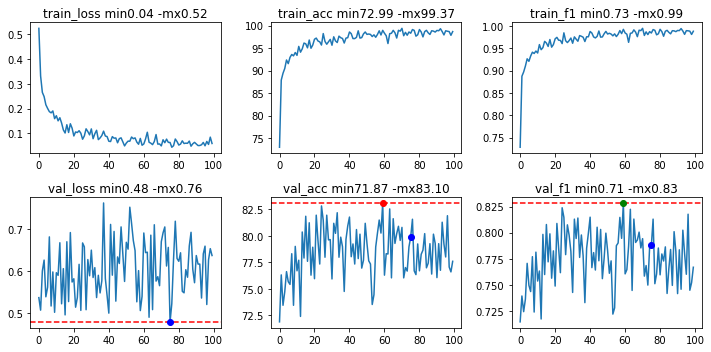

In [5]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 200
hop = 200
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 20
mask_x_len = 20
lr=1e-4
model_name = "inception"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 200 hop = 200 
optim = Adam lr=0.0001 
mask_y_len = 30 mask_x_len = 30 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 3.3562291781107585
Maxx val acc: 83.17948717948718


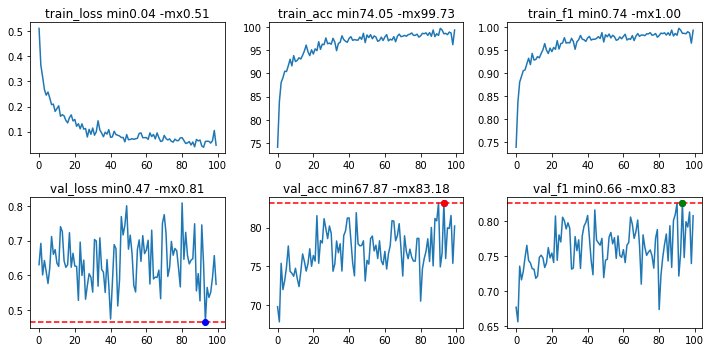

In [6]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 200
hop = 200
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 30
mask_x_len = 30
lr=1e-4
model_name = "inception"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = inception 
data_input =  audio 
win_len = 200 hop = 50 
optim = Adam lr=0.0001 
mask_y_len = 30 mask_x_len = 30 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 13.300182072321574
Maxx val acc: 83.43506493506493


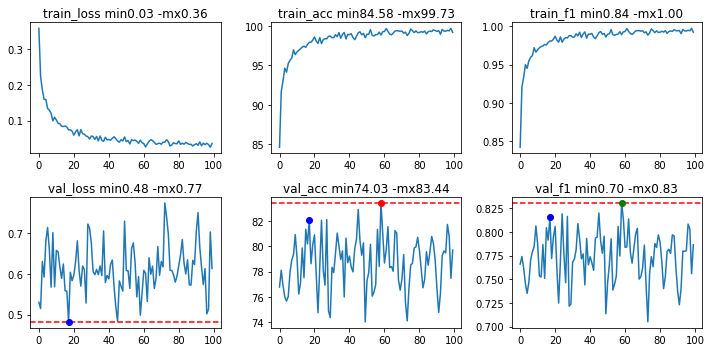

In [7]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 200
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 30
mask_x_len = 30
lr=1e-4
model_name = "inception"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = FCNN_short 
data_input =  audio 
win_len = 100 hop = 50 
optim = Adam lr=0.0001 
mask_y_len = 30 mask_x_len = 30 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 11.089715719223022
Maxx val acc: 66.23529411764706


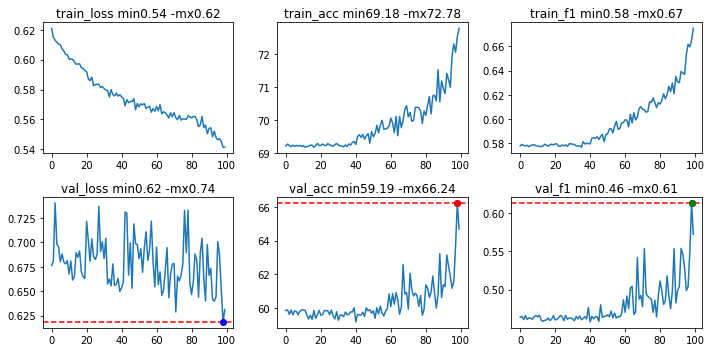

In [8]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 30
mask_x_len = 30
lr=1e-4
model_name = "FCNN_short"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = FCNN_short 
data_input =  audio 
win_len = 100 hop = 50 
optim = Adam lr=0.001 
mask_y_len = 30 mask_x_len = 30 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 11.17050453821818
Maxx val acc: 59.89542483660131


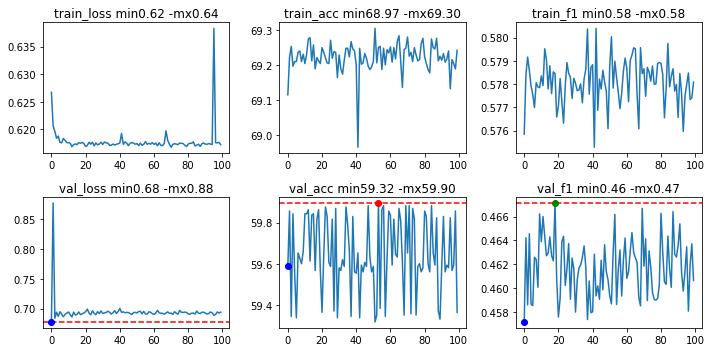

In [9]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 30
mask_x_len = 30
lr=1e-3
model_name = "FCNN_short"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = FCNN_short 
data_input =  audio 
win_len = 100 hop = 50 
optim = Adam lr=0.0001 
mask_y_len = 30 mask_x_len = 30 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 11.154760694503784
Maxx val acc: 70.38562091503267


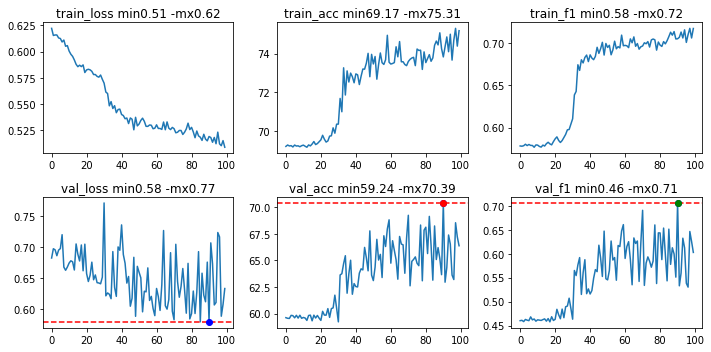

In [10]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 30
mask_x_len = 30
lr=1e-4
model_name = "FCNN_short"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = FCNN_short 
data_input =  audio 
win_len = 100 hop = 50 
optim = Adam lr=1e-05 
mask_y_len = 30 mask_x_len = 30 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 11.208665164311727
Maxx val acc: 70.6470588235294


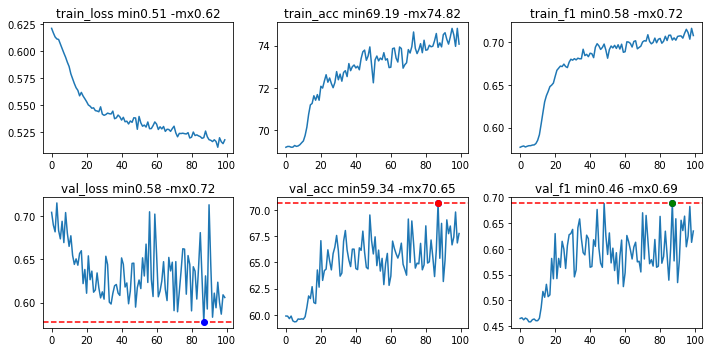

In [11]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 30
mask_x_len = 30
lr=1e-5
model_name = "FCNN_short"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = FCNN_short 
data_input =  audio 
win_len = 100 hop = 50 
optim = Adam lr=1e-05 
mask_y_len = 30 mask_x_len = 30 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 200 split = individ 
Finished Training in 22.469753567377726
Maxx val acc: 73.77124183006536


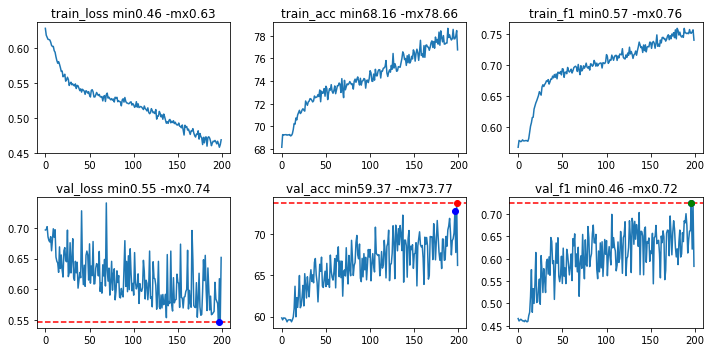

In [12]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 200
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 30
mask_x_len = 30
lr=1e-5
model_name = "FCNN_short"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

Finished Training in 46.95837225914001
Maxx val acc: 74.77124183006536


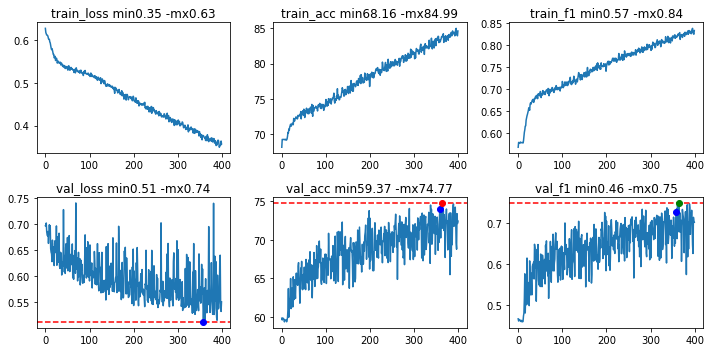

In [13]:
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")


In [14]:
lr

1e-05

model_name = FCNN_short 
data_input =  audio 
win_len = 100 hop = 50 
optim = Adam lr=1e-05 
mask_y_len = 20 mask_x_len = 20 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 200 split = individ 
Finished Training in 22.444436105092368
Maxx val acc: 73.45751633986929


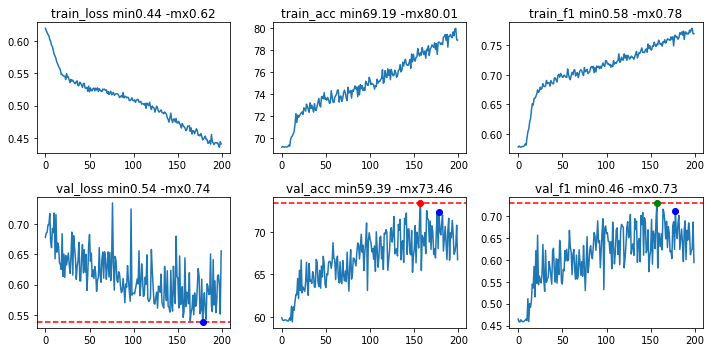

In [15]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 200
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 20
mask_x_len = 20
lr=1e-5
model_name = "FCNN_short"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

model_name = FCNN_short 
data_input =  audio 
win_len = 100 hop = 50 
optim = Adam lr=1e-06 
mask_y_len = 10 mask_x_len = 10 
vad_min = 0.5  g1, g0 = Ataxia Control 
batch_train = 8 batch_val = 8  
n_epochs = 100 split = individ 
Finished Training in 11.19106976588567
Maxx val acc: 61.66013071895425


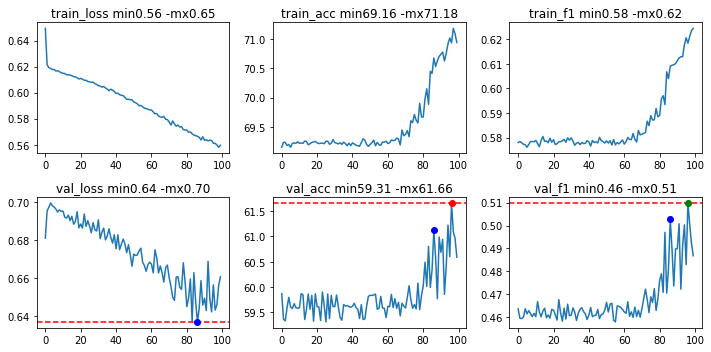

In [16]:
import numpy as np
import time
import pickle
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchaudio.transforms as T
from DL_utils import get_data, MyDataset, MyDataset_2data, inception_model, FCNN_short, binary_acc, multiinception_model

win_len = 100
hop = 50
vad_min = .5
g1, g0 = 'Ataxia', 'Control'
batch_train = 8
batch_val = 8 # all if -1
dev_num = 3
data_input = "audio"  # "face" #    "multi" #
n_epochs = 100
split = 'individ'
optim = "Adam" # "SGD"# 
mask_y_len = 10
mask_x_len = 10
lr=1e-6
model_name = "FCNN_short"

print(f"model_name = {model_name} \ndata_input =  {data_input} \nwin_len = {win_len} hop = {hop} \noptim = {optim} lr={lr} \nmask_y_len = {mask_y_len} mask_x_len = {mask_x_len} \n\
vad_min = {vad_min}  g1, g0 = {g1} {g0} \nbatch_train = {batch_train} batch_val = {batch_val}  \nn_epochs = {n_epochs} \
split = {split} ")

# Get dataset
fname = f'Oculomotor_Cookie_Theft_face_dataset_cut_media_flhNone-30_min_win4_audio_commFs50.pickle'
# fname = 'Oculomotor_Cookie_Theft_face_dataset_cut_media_dwnsmp-4_flhNone-30_audio.pickle'
with open(fname, "rb") as f:
    dataset = pickle.load(f)

# Remove other groups
ids = list(dataset)
for k in ids:
    if dataset[k]['beh']['gen_diagnosis'] not in [g1,g0]:
        del dataset[k]

# Split data into groups
ids = np.array(list(dataset))
labels = [dataset[k]['beh']['gen_diagnosis'] for k in ids]
labels = [ 1 if l == g1 else 0 for l in labels]


if split == "strat":
    train_inx, val_inx = train_test_split(list(range(len(labels))), test_size=.3,
                                          random_state=1, stratify=labels)
elif split == "individ":
    IDs = [i[:5] for i in list(dataset.keys())]
    idxs, inx, groups = np.unique(IDs, return_index=True, return_inverse=True)
    gss= GroupShuffleSplit(1, train_size=.8, random_state=1)
    train_inx, val_inx =  next(gss.split(list(range(len(labels))), None, groups))

data_train = {k:v for k,v in dataset.items() if k in ids[train_inx]}
data_val = {k:v for k,v in dataset.items() if k in ids[val_inx]}

x_ts_train, x_S_train, y_train, sbj_ids_train, inx_win = get_data(data_train, win_len, hop, vad_min, pose_dims=2)
x_ts_val, x_S_val, y_val, sbj_ids_val, _ = get_data(data_val, win_len, hop, vad_min,  pose_dims=2)
y_train = [ 1 if l == g1 else 0 for l in y_train]
y_val = [ 1 if l == g1 else 0 for l in y_val]

# Create Dataloaders
transform = transforms.Compose([ 
                                T.TimeMasking(time_mask_param=mask_x_len),
                                T.FrequencyMasking(freq_mask_param =mask_y_len)
                                ])

if data_input == "face":
    dataset_t = MyDataset(x_ts_train, y_train, transform=transform)
    dataset_v = MyDataset(x_ts_val, y_val, transform=transform)
elif data_input == "audio":
    dataset_t = MyDataset(x_S_train, y_train, transform=transform)
    dataset_v = MyDataset(x_S_val, y_val, transform=transform)    
elif data_input == "multi":
    dataset_t = MyDataset_2data(x_ts_train, x_S_train, y_train, transform=transform)
    dataset_v = MyDataset_2data(x_ts_val, x_S_val, y_val, transform=transform)
    
dataloader_t = DataLoader(dataset_t, batch_size=batch_train, shuffle=True, drop_last=True, pin_memory=True)
batch_size = len(dataset_v) if batch_val < 0 else batch_val
dataloader_v = DataLoader(dataset_v, batch_size=batch_size, shuffle=True, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda" and dev_num is not None:
    device = torch.device(f'cuda:{dev_num}')

#Set up ML
if data_input == "multi":
    in_chans1 = dataloader_t.dataset.data_pose[0].shape[0]
    in_chans2 = dataloader_t.dataset.data_aud[0].shape[0]
    net = multiinception_model(in_chans1, in_chans2)
    net_name = "inception"
elif model_name == "FCNN_short":
    net_name = model_name
    net = FCNN_short()
else:
    in_chans = dataloader_t.dataset.data[0].shape[0]
    net = inception_model(in_chans)
    net_name = "inception"

t0 = time.time()
if device == "cuda" and dev_num is None:
    net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss().to(device)
if optim == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay= 0.01)
elif optim == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay= 0.01)

train_f1 = torchmetrics.F1(num_classes=2, average='weighted')
train_f1.to(device)
metrics = {k:[] for k in["train_loss", "train_acc", "val_loss", "val_acc","train_f1", "val_f1"]}
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")

Finished Training in 23.523975499471028
Maxx val acc: 66.45751633986929


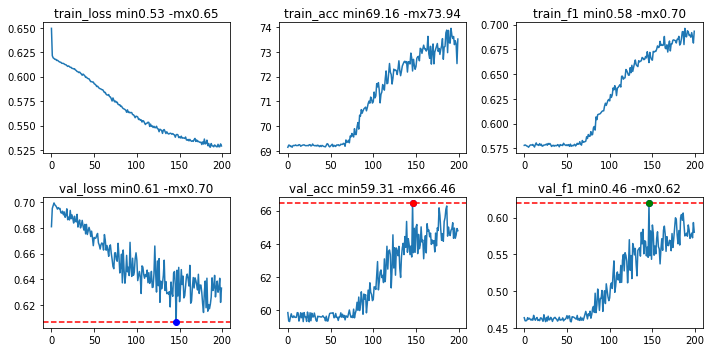

In [17]:

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader_t):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward + backward + optimize
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])

        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)
        acc = binary_acc(outputs, labels[:,0])
        f1 = train_f1(outputs, labels[:,0])
        
        loss.backward()
        optimizer.step()
        
        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["train_loss"].append(running_loss / len(dataloader_t))
    metrics["train_acc"].append(running_acc / len(dataloader_t))
    metrics["train_f1"].append(running_f1 / len(dataloader_t))

    running_loss, running_acc, running_f1 = 0.0, 0., 0.0
    for i, data in enumerate(dataloader_v):
        if data_input == "multi":
            inputs1, inputs2, labels = data
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
        else:            
            inputs, labels = data
            if model_name == "FCNN_short":
                inputs = torch.unsqueeze(inputs, dim=1)
            inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = labels.type(torch.long)
        labels = labels.unsqueeze(1)

        # forward
        if data_input == "multi":
            outputs = net(inputs1, inputs2)
        else:
            outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        
        outputs = torch.argmax(F.softmax(outputs,dim =1), dim =1)        
        acc = binary_acc(outputs, labels[:, 0])
        f1 = train_f1(outputs, labels[:,0])

        running_f1 += f1.item()
        running_loss += loss.item()
        running_acc += acc.item()

    metrics["val_loss"].append(running_loss / len(dataloader_v))
    metrics["val_acc"].append(running_acc / len(dataloader_v))
    metrics["val_f1"].append(running_f1 / len(dataloader_v))
    
    # print(f'epoch {epoch} Train loss: {metrics["train_loss"][-1]:.3f} ',
    #       f'Train acc: {metrics["train_acc"][-1]:.3f}',
    #       f'Train f1: {metrics["train_f1"][-1]:.3f}',
    #       f'Val loss:{metrics["val_loss"][-1]:.3f} ',
    #       f'Val acc: {metrics["val_acc"][-1]:.3f}',
    #       f'Val f1: {metrics["val_f1"][-1]:.3f}')

t1 = time.time()
ttot = t1 - t0
print(f'Finished Training in {ttot/60}')


title = net_name

fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.canvas.set_window_title(title)
for ax, tt in zip(axs.flatten(),['train_loss', 'train_acc', 'train_f1', 'val_loss', 'val_acc',  "val_f1"]):
    ax.plot(metrics[tt])
    mn, mx = min(metrics[tt]), max(metrics[tt])
    ax.set_title(tt + f" min{mn:.2f} -mx{mx:.2f}")
print(f"Maxx val acc: {max(metrics['val_acc'])}")
axs.flatten()[3].axhline(min(metrics['val_loss']), color="r", linestyle="--")
loss_min = np.argmin(metrics['val_loss'])
axs.flatten()[3].plot(loss_min, min(metrics['val_loss']), "bo")
axs.flatten()[4].plot(loss_min, metrics['val_acc'][loss_min], "bo")
axs.flatten()[5].plot(loss_min, metrics['val_f1'][loss_min], "bo")

axs.flatten()[4].axhline(max(metrics['val_acc']), color="r", linestyle="--")
axs.flatten()[4].plot(np.argmax(metrics['val_acc']),max(metrics['val_acc']), "ro")

axs.flatten()[5].axhline(max(metrics['val_f1']), color="r", linestyle="--")
axs.flatten()[5].plot(np.argmax(metrics['val_f1']),max(metrics['val_f1']), "go")

fig.tight_layout()
# fig.savefig(f"result_figs/{title}_2Dist_inception__{win_len}wz_{hop}st_{g1}vs{g0}_valBatch{batch_val}_{round(ttot/60)}mintime.png")



In [18]:

import numpy as np
import pickle
import matplotlib.pyplot as plt

import cv2, sys, dlib, math
import numpy as np

#similarity transform given two pairs of corresponding points. OpenCV requires 3 points for calculating similarity matrix.
#We are assuming the third point as the third point of the eqillateral triangle with these two given points.
def similarityTransformMat(initialPoints, destinationPoints):
        sin60 = math.sin(60*math.pi / 180)
        cos60 = math.cos(60*math.pi / 180)

        #third point is caluculated for initial points
        xin = cos60*(initialPoints[0][0] - initialPoints[1][0]) - sin60*(initialPoints[0][1] - initialPoints[1][1]) + initialPoints[1][0]
        yin = sin60*(initialPoints[0][0] - initialPoints[1][0]) + cos60*(initialPoints[0][1] - initialPoints[1][1]) + initialPoints[1][1]

        initialPoints = np.append(initialPoints,[ [int(xin), int(yin)]], axis=0)

        #third point is caluculated for destination points
        xout = cos60*(destinationPoints[0][0] - destinationPoints[1][0]) - sin60*(destinationPoints[0][1] - destinationPoints[1][1]) + destinationPoints[1][0]
        yout = sin60*(destinationPoints[0][0] - destinationPoints[1][0]) + cos60*(destinationPoints[0][1] - destinationPoints[1][1]) + destinationPoints[1][1]

        destinationPoints= np.append(destinationPoints, [[int(xout), int(yout)]], axis=0)

        # calculate similarity transform.
        tform = cv2.estimateAffinePartial2D(np.array([initialPoints]), np.array([destinationPoints]))
        return tform[0]

#face Alignes a facial image to a standard size. The normalization is done based on Dlib's landmark points.
#After the normalization the left corner of the left eye is at (0.3*w, h/3) and the right corner of the right eye 
#is at (0.7*w, h/3) where w and h are the width and height of standard size.
def faceAlign(image, size, faceLandmarks):

        


        #apply similarity transform
        faceAligned = cv2.warpAffine(image, similarityTransform, (w, h))

        return faceAligned



#align face image
faceAligned = faceAlign(image, size, faceLandmarks)



fname = "Oculomotor_Cookie_Theft_face_dataset_cut_filt-median_dwnsmp-2_dict.pickle"
with open(fname, "rb") as f:
    dataset = pickle.load(f)


pnts_inx = [36, 45]  # 30
k = list(dataset)[0]

grp_inx = []

for k in  list(dataset)[0]:
    pos_raw = dataset[k]['ts']
    
    pos_op_m = np.nanmean(pos_raw, 0)[:,:2]  #/ np.nanstd(pos_raw, 0)[:,:2]
    
    init_pnts = pos_op_m[pnts_inx]
    dest_pnts = pos_raw[0, :, :2]
    #calculate similarity transform
    # similarityTransform = similarityTransformMat(init_pnts, dest_pnts)
    
    tform = cv2.estimateAffinePartial2D(init_pnts, dest_pnts[pnts_inx])[0]
    
    new_pnt = pos_raw[10, :, :2]
    pnt_diff = np.append(dest_pnts - new_pnt, np.ones([new_pnt.shape[0],1]), 1)
     
    pnt_trans = np.dot(tform, pnt_diff.T).T + pos_op_m
    
    
# plt.scatter(pos_med_m[:, 0], pos_med_m[:, 1], color='y', alpha=.5)
plt.scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
plt.scatter(pnt_trans[:,0], pnt_trans[:,1], color='g',alpha=.5)


NameError: name 'image' is not defined

In [19]:


fname = "Oculomotor_Cookie_Theft_face_dataset_cut_filt-median_dwnsmp-2_dict.pickle"
with open(fname, "rb") as f:
    dataset = pickle.load(f)


pnts_inx = [36, 45]  # 30
k = list(dataset)[0]

grp_inx = []

for k in  list(dataset)[0]:
    pos_raw = dataset[k]['ts']
    
    pos_op_m = np.nanmean(pos_raw, 0)[:,:2]  #/ np.nanstd(pos_raw, 0)[:,:2]
    
    init_pnts = pos_op_m[pnts_inx]
    dest_pnts = pos_raw[0, :, :2]
    #calculate similarity transform
    # similarityTransform = similarityTransformMat(init_pnts, dest_pnts)
    
    tform = cv2.estimateAffinePartial2D(init_pnts, dest_pnts[pnts_inx])[0]
    
    new_pnt = pos_raw[10, :, :2]
    pnt_diff = np.append(dest_pnts - new_pnt, np.ones([new_pnt.shape[0],1]), 1)
     
    pnt_trans = np.dot(tform, pnt_diff.T).T + pos_op_m
    
    
# plt.scatter(pos_med_m[:, 0], pos_med_m[:, 1], color='y', alpha=.5)
plt.scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
plt.scatter(pnt_trans[:,0], pnt_trans[:,1], color='g',alpha=.5)
    
    
    

KeyError: '1'

In [20]:
k

'1'

In [21]:
 list(dataset)

['10002_2018_09_12',
 '10007_2018_04_25',
 '10042_2018_09_27',
 '10045_2018_11_28',
 '10049_2018_04_25',
 '10050_2018_10_25',
 '10053_2018_05_24',
 '10053_2018_09_12',
 '10053_2018_12_20',
 '10056_2018_04_11',
 '10060_2018_11_08',
 '10066_2019_11_21',
 '10068_2018_11_14',
 '10081_2019_11_20',
 '10082_2018_05_30',
 '10082_2018_12_05',
 '10087_2018_05_30',
 '10089_2018_09_13',
 '10090_2019_03_29',
 '10093_2018_12_20',
 '10094_2018_05_10',
 '10094_2018_11_01',
 '10094_2019_03_13',
 '10094_2019_09_19',
 '10100_2018_06_13',
 '10100_2018_12_13',
 '10100_2019_12_19',
 '10101_2018_06_27',
 '10102_2018_06_21',
 '10105_2019_02_27',
 '10105_2019_11_06',
 '10107_2019_02_20',
 '10108_2020_02_14',
 '10109_2020_02_14',
 '10113_2019_01_11',
 '10114_2019_01_11',
 '10115_2019_04_01',
 '10118_2019_01_10',
 '10119_2019_01_12',
 '10122_2020_01_09',
 '10123_2019_01_11',
 '10123_2020_01_09',
 '10124_2019_01_10',
 '10124_2020_01_10',
 '10125_2019_01_10',
 '10135_2019_03_01',
 '10136_2019_03_01',
 '10143_2018_

In [22]:
 list(dataset)[0]
 

'10002_2018_09_12'

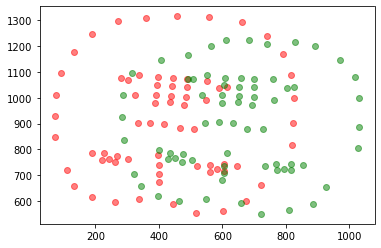

In [23]:

for k in  list(dataset)[0:1]:
    pos_raw = dataset[k]['ts']
    
    pos_op_m = np.nanmean(pos_raw, 0)[:,:2]  #/ np.nanstd(pos_raw, 0)[:,:2]
    
    init_pnts = pos_op_m[pnts_inx]
    dest_pnts = pos_raw[0, :, :2]
    #calculate similarity transform
    # similarityTransform = similarityTransformMat(init_pnts, dest_pnts)
    
    tform = cv2.estimateAffinePartial2D(init_pnts, dest_pnts[pnts_inx])[0]
    
    new_pnt = pos_raw[10, :, :2]
    pnt_diff = np.append(dest_pnts - new_pnt, np.ones([new_pnt.shape[0],1]), 1)
     
    pnt_trans = np.dot(tform, pnt_diff.T).T + pos_op_m
    
    
# plt.scatter(pos_med_m[:, 0], pos_med_m[:, 1], color='y', alpha=.5)
plt.scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
plt.scatter(pnt_trans[:,0], pnt_trans[:,1], color='g',alpha=.5)
    
    

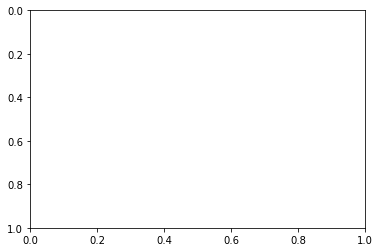

In [24]:
plt.gca().invert_yaxis()

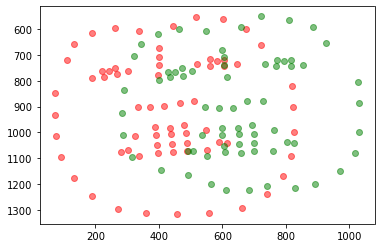

In [25]:
plt.scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
plt.scatter(pnt_trans[:,0], pnt_trans[:,1], color='g',alpha=.5)
plt.gca().invert_yaxis()

NameError: name 'dest_new' is not defined

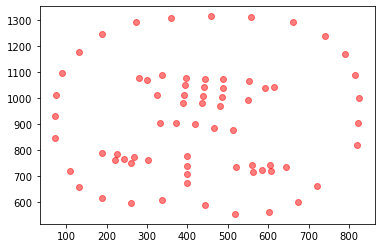

In [26]:

# plt.scatter(pos_med_m[:, 0], pos_med_m[:, 1], color='y', alpha=.5)
plt.scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
plt.scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
plt.gca().invert_yaxis()
    
    

In [27]:

    dest_new = np.dot(tform, np.append(dest_pnts, np.ones([dest_pnts.shape[0],1]),1).T).T
    
    

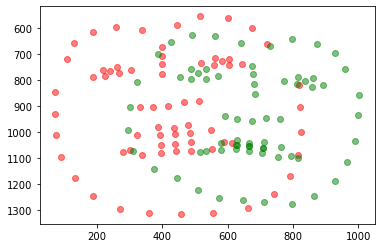

In [28]:

# plt.scatter(pos_med_m[:, 0], pos_med_m[:, 1], color='y', alpha=.5)
plt.scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
plt.scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
plt.gca().invert_yaxis()
    
    

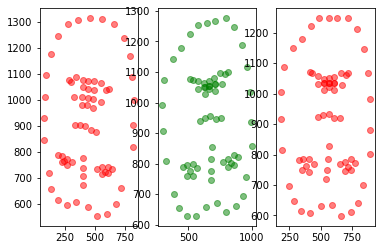

In [29]:
fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[1].scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
axs[2].scatter(dest_pnts[:, 0], dest_pnts[:, 1], color='r',alpha=.5)

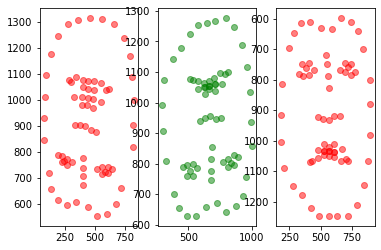

In [30]:
fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[1].scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
axs[2].scatter(dest_pnts[:, 0], dest_pnts[:, 1], color='r',alpha=.5)
plt.gca().invert_yaxis()

AttributeError: 'AxesSubplot' object has no attribute 'gca'

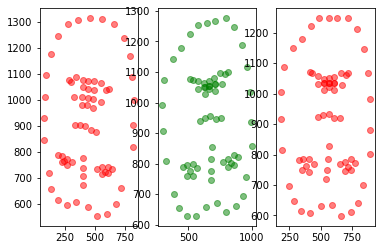

In [31]:
fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[1].scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
axs[2].scatter(dest_pnts[:, 0], dest_pnts[:, 1], color='r',alpha=.5)
axs[0].gca().invert_yaxis()

[None, None, None]

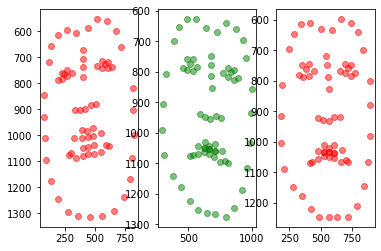

In [32]:
fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[1].scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
axs[2].scatter(dest_pnts[:, 0], dest_pnts[:, 1], color='r',alpha=.5)
[ax.invert_yaxis() for ax in axs]


[None, None, None]

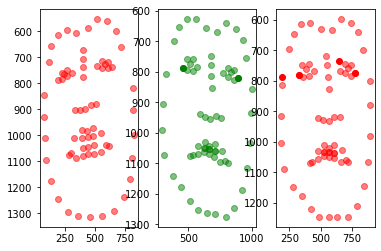

In [33]:

fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[2].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='r')
axs[1].scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
axs[1].scatter(dest_new[pnts_inx,0], dest_new[pnts_inx,1], color='g')
axs[2].scatter(dest_pnts[:, 0], dest_pnts[:, 1], color='r',alpha=.5)
axs[2].scatter(dest_pnts[pnts_inx,0], dest_pnts[pnts_inx,1], color='r')
[ax.invert_yaxis() for ax in axs]

[None, None, None]

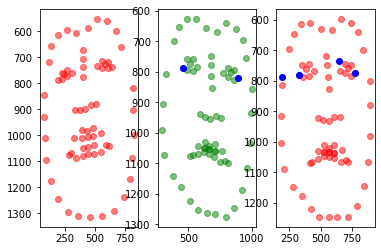

In [34]:
fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[2].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='b')
axs[1].scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
axs[1].scatter(dest_new[pnts_inx,0], dest_new[pnts_inx,1], color='b')
axs[2].scatter(dest_pnts[:, 0], dest_pnts[:, 1], color='r',alpha=.5)
axs[2].scatter(dest_pnts[pnts_inx,0], dest_pnts[pnts_inx,1], color='b')
[ax.invert_yaxis() for ax in axs]

[None, None, None]

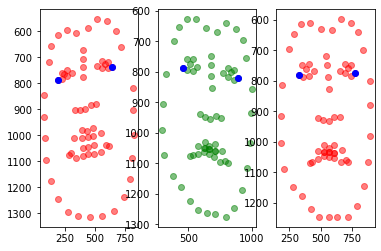

In [35]:

fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[0].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='b')
axs[1].scatter(dest_new[:,0], dest_new[:,1], color='g',alpha=.5)
axs[1].scatter(dest_new[pnts_inx,0], dest_new[pnts_inx,1], color='b')
axs[2].scatter(dest_pnts[:, 0], dest_pnts[:, 1], color='r',alpha=.5)
axs[2].scatter(dest_pnts[pnts_inx,0], dest_pnts[pnts_inx,1], color='b')
[ax.invert_yaxis() for ax in axs]

In [36]:

    init_pnts =  pos_raw[0, :, :2]
    dest_pnts = pos_op_m[pnts_inx]
    #calculate similarity transform
    # similarityTransform = similarityTransformMat(init_pnts, dest_pnts)
    
    tform = cv2.estimateAffinePartial2D(init_pnts, dest_pnts[pnts_inx])[0]
    
    init_new = np.dot(tform, np.append(init_pnts, np.ones([init_pnts.shape[0],1]),1).T).T
    
    new_pnt = pos_raw[10, :, :2]
    pnt_diff = np.append(dest_pnts - new_pnt, np.ones([new_pnt.shape[0],1]), 1)
    pnt_trans = np.dot(tform, pnt_diff.T).T + pos_op_m
    

IndexError: index 36 is out of bounds for axis 0 with size 2

In [37]:

    tform = cv2.estimateAffinePartial2D(init_pnts[pnts_inx], dest_pnts)[0]
    
    init_new = np.dot(tform, np.append(init_pnts, np.ones([init_pnts.shape[0],1]),1).T).T
    
    new_pnt = pos_raw[10, :, :2]
    pnt_diff = np.append(dest_pnts - new_pnt, np.ones([new_pnt.shape[0],1]), 1)
    pnt_trans = np.dot(tform, pnt_diff.T).T + pos_op_m
    

ValueError: operands could not be broadcast together with shapes (2,2) (70,2) 

[None, None, None]

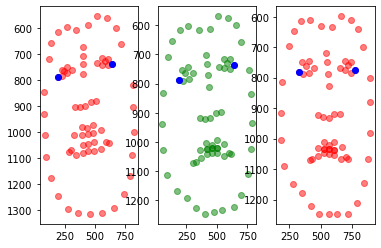

In [38]:

fig, axs = plt.subplots(1,3)
axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
axs[0].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='b')
axs[1].scatter(init_new[:,0], init_new[:,1], color='g',alpha=.5)
axs[1].scatter(init_new[pnts_inx,0], init_new[pnts_inx,1], color='b')
axs[2].scatter(init_pnts[:, 0], init_pnts[:, 1], color='r',alpha=.5)
axs[2].scatter(init_pnts[pnts_inx,0], init_pnts[pnts_inx,1], color='b')
[ax.invert_yaxis() for ax in axs]

    

[None, None, None, None]

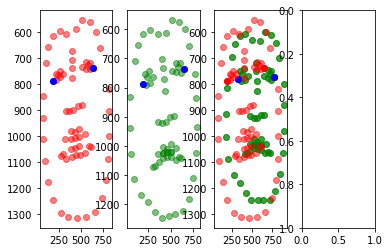

In [39]:

    fig, axs = plt.subplots(1,4)
    axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
    axs[0].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='b')
    axs[1].scatter(init_new[:,0], init_new[:,1], color='g',alpha=.5)
    axs[1].scatter(init_new[pnts_inx,0], init_new[pnts_inx,1], color='b')
    axs[2].scatter(init_pnts[:, 0], init_pnts[:, 1], color='g',alpha=.5)
    axs[2].scatter(init_pnts[pnts_inx,0], init_pnts[pnts_inx,1], color='b')
    
    axs[2].scatter(init_pnts[:, 0], init_pnts[:, 1], color='g',alpha=.5)
    axs[2].scatter(init_pnts[pnts_inx,0], init_pnts[pnts_inx,1], color='b')
    axs[2].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
    axs[2].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='r')
    
    [ax.invert_yaxis() for ax in axs]


[None, None, None, None]

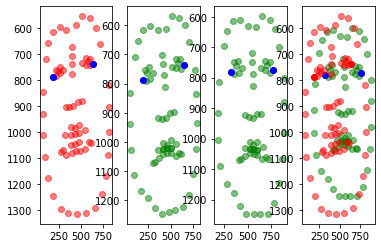

In [40]:
  
    fig, axs = plt.subplots(1,4)
    axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
    axs[0].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='b')
    axs[1].scatter(init_new[:,0], init_new[:,1], color='g',alpha=.5)
    axs[1].scatter(init_new[pnts_inx,0], init_new[pnts_inx,1], color='b')
    axs[2].scatter(init_pnts[:, 0], init_pnts[:, 1], color='g',alpha=.5)
    axs[2].scatter(init_pnts[pnts_inx,0], init_pnts[pnts_inx,1], color='b')
    
    axs[3].scatter(init_pnts[:, 0], init_pnts[:, 1], color='g',alpha=.5)
    axs[3].scatter(init_pnts[pnts_inx,0], init_pnts[pnts_inx,1], color='b')
    axs[3].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
    axs[3].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='r')
    
    [ax.invert_yaxis() for ax in axs]

[None, None, None, None]

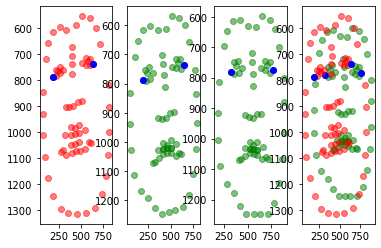

In [41]:
    fig, axs = plt.subplots(1,4)
    axs[0].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
    axs[0].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='b')
    axs[1].scatter(init_new[:,0], init_new[:,1], color='g',alpha=.5)
    axs[1].scatter(init_new[pnts_inx,0], init_new[pnts_inx,1], color='b')
    axs[2].scatter(init_pnts[:, 0], init_pnts[:, 1], color='g',alpha=.5)
    axs[2].scatter(init_pnts[pnts_inx,0], init_pnts[pnts_inx,1], color='b')
    
    axs[3].scatter(init_pnts[:, 0], init_pnts[:, 1], color='g',alpha=.5)
    axs[3].scatter(init_pnts[pnts_inx,0], init_pnts[pnts_inx,1], color='b')
    axs[3].scatter(pos_op_m[:, 0], pos_op_m[:, 1], color='r',alpha=.5)
    axs[3].scatter(pos_op_m[pnts_inx,0], pos_op_m[pnts_inx,1], color='b')
    
    [ax.invert_yaxis() for ax in axs]

In [42]:
dest_pnts

array([[188.22792737, 787.7885307 ],
       [644.61348082, 736.92030442]])